# Michał Matak - Modele Bayesowskie do mapowania położenia obiektu



## Importowanie bibliotek
* numpy - operacje na macierzach 
* statistics - wyznaczenie średniej i wariancji
* matplotlib - tworzenie wykresów
* itertools - tworzenie wszytkich kombinacji dwu-elementowych zbioru
* math - funkcje matematyczne oraz stałe

In [1]:
import numpy as np
import statistics as stat
from matplotlib import pyplot as plt
from itertools import combinations
from math import exp, sqrt, pi, inf
from data_operations import get_data, split_into_classes, split_into_sets, get_dictionary_axes
from data_operations import test, create_heatmap, create_classification_heatmap, calculate_precision, calculate_recall, create_class_heatmap
import csv

In [2]:
def encode(number, data_dictionary):
    return number

def decode(number):
    return number

In [3]:
data, data_dictionary = get_data("series4", encode)

In [4]:
def get_feature(data, feature, object_class=None):
    return [record[0][feature] for record in data if not object_class or (record[1] == object_class)]

## Funkcje związane z klasyfikatorem Bayesowskim

Wyliczanie wartości rozkładu normalnego dla podanej średniej i odchylenia standardowego:

In [5]:
def gauss(x, mean, std_deviation):
    numerator = exp(-((x - mean)**2)/(2*std_deviation**2))
    denominator = std_deviation * sqrt(2*pi)
    return numerator/denominator

Zwrócenie parametrów modelu dla danego atrybutu i wszystkich klas w formie listy:

In [6]:
def train_parameters(data, feature):
    data_list = []
    for element in data_dictionary.values():
        temporary_list = get_feature(data, feature, element)
        data_list.append([stat.mean(temporary_list), stat.stdev(temporary_list)])
    return data_list

## Funkcja classify

Funkcja **classify**, jako argument przyjmuje element ze zbioru danych, zbiór danych, a także dwie liczby określające zgodnie według jakich atrybutów klasyfikować element. Wskazywana jest taka klasa $y$ dla której wartość wyrażenia:
<center>$P(x_i|y)\cdot P(x_j|y)\cdot P(y)$</center>
jest największa.  

Wartości $P(x_i|y)$ i $P(x_j|y)$ są obliczane na podstawie rozkładu Gaussa, którego parametry dla każdej klasy obliczane są przez funkcję *train_parameters* . Wartość $P(y)$ jest obliczana w specyficzny sposób, gdyż jest to długość listy wartości jakiegoś atrybutu dla klasy $y$ podzielona przez tą długość dla wszystkich klas.

In [7]:
def train(data):
    return [train_parameters(data, 0), train_parameters(data, 1), train_parameters(data, 2)]

In [8]:
def predict(element, train_par):
    parameters1, parameters2, parameters3 = train_par
    maximum = -inf
    object_class = -inf
    for i in range(len(data_dictionary)):
        value = gauss(element[0], *parameters1[i]) * gauss(element[1], *parameters2[i])* gauss(element[2], *parameters3[i])*(len(data)/len(get_feature(data, 0, i+1)))
        if (value > maximum): 
            object_class = i
            maximum = value
    return object_class + 1

## Ewaluacja - sprawdzenie działania algorytmu

Poniżej znajduje się funkcja, który sprawdza stopień poprawnośći przewidywań przez naiwny klasyfikator Bayesowski. Jako parametry przyjmuje zbiór testowy, treningowy oraz liczby określające atrybuty. W zbiorze testowym na pierwszym miejscu każdego elementu jest liczba oznaczająca klasę, która jest porównywana ze wskazaniem modelu. Jeśli model się pomylił dodawana jest jedynka do liczby błędów.

In [9]:
def evaluate(test_set, train_set):
    errors = 0
    train_par = train(train_set)
    for element in test_set:
        if (element[1] != predict(element, train_par)): errors += 1
    return errors/(len(train_set))

## Działanie programu

In [10]:
train_set, test_set = split_into_sets(0.75, data)
train_par = train(train_set)
class_vector = split_into_classes(train_set, data_dictionary, decode)


In [11]:
len(class_vector[1])

750

In [ ]:
classification_array = test(class_vector, predict, [train_par])

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183


523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632


233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482


107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356


728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245

581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115

493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742


400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649


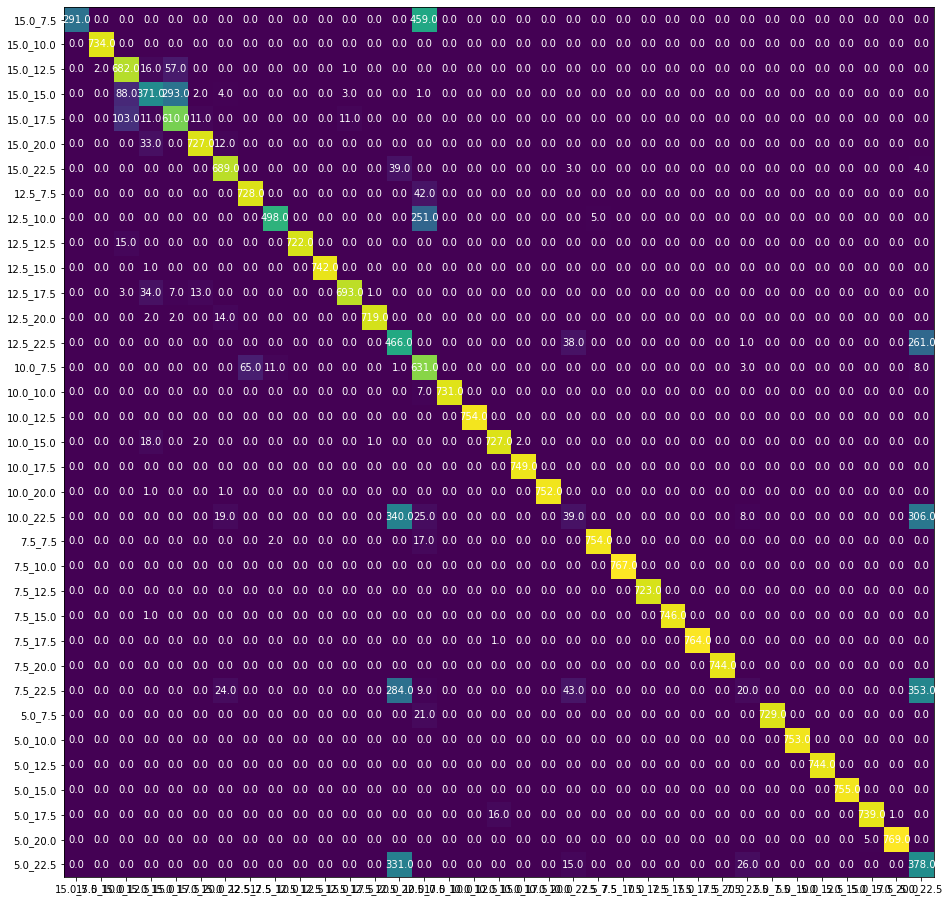

In [14]:
create_classification_heatmap(classification_array, data_dictionary)

C:\Users\micha\HOME\Fingmap\Data\data_operations.py:163: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


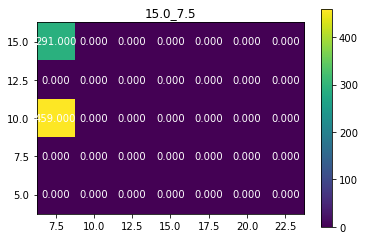

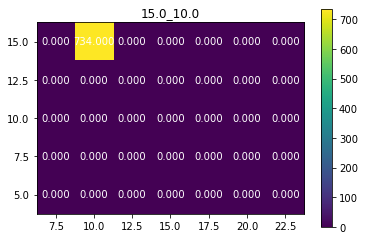

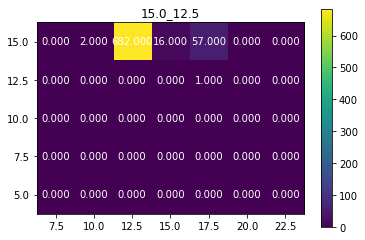

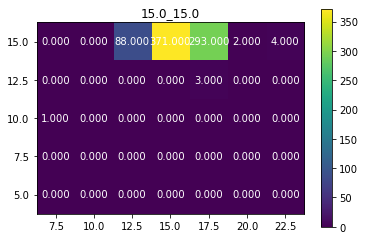

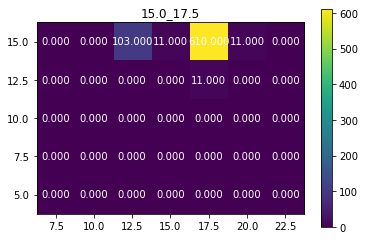

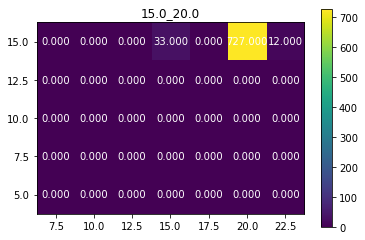

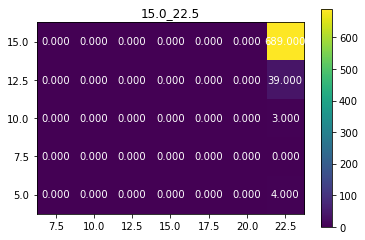

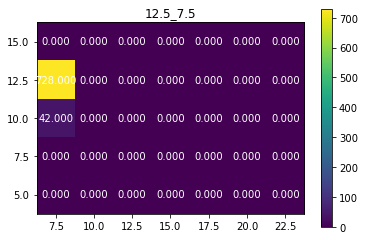

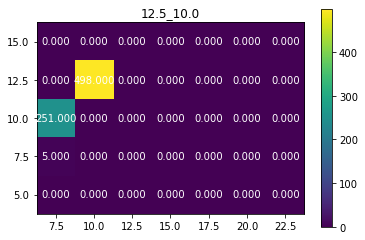

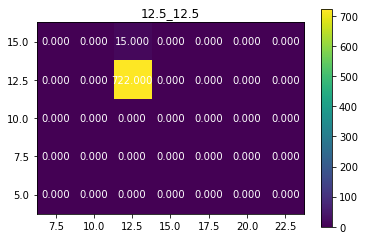

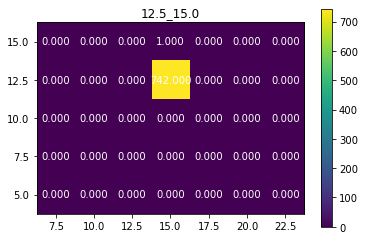

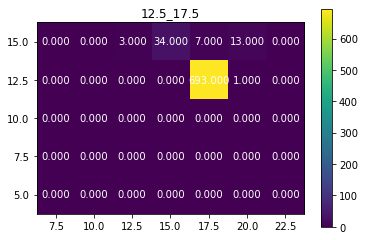

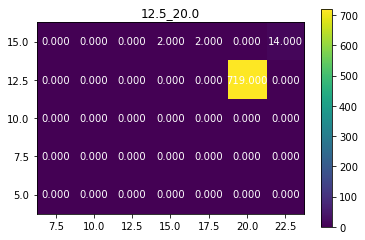

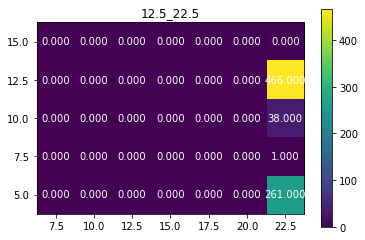

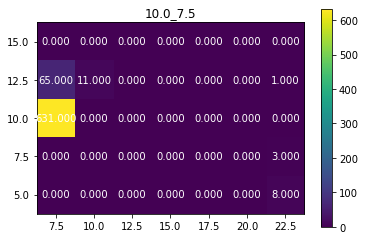

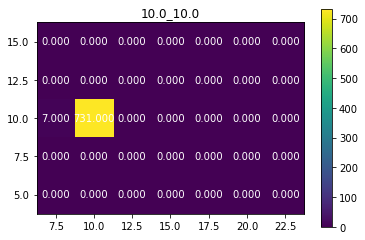

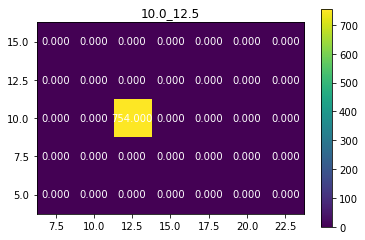

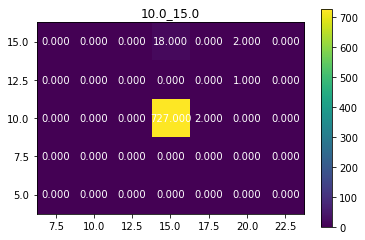

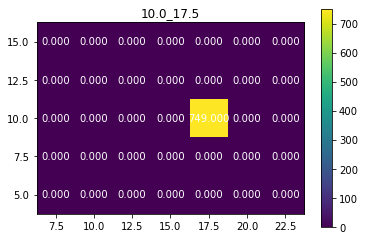

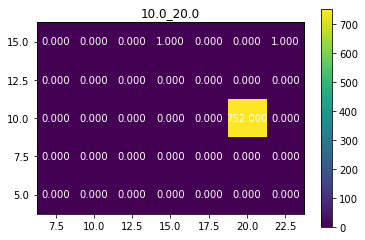

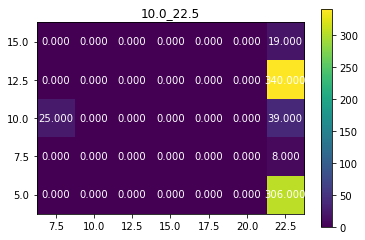

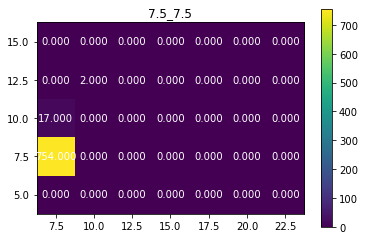

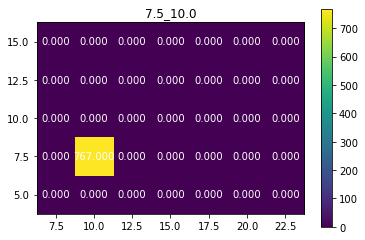

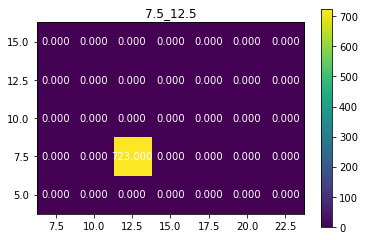

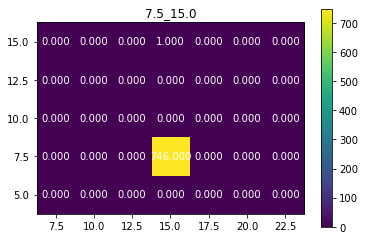

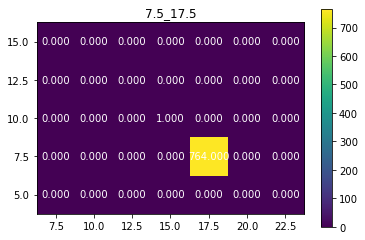

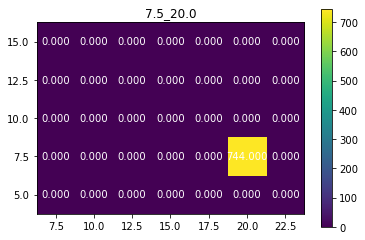

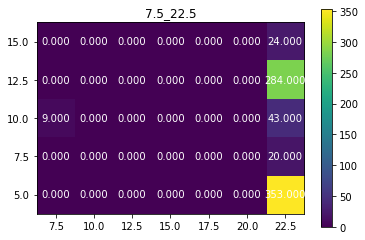

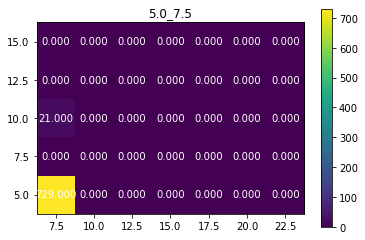

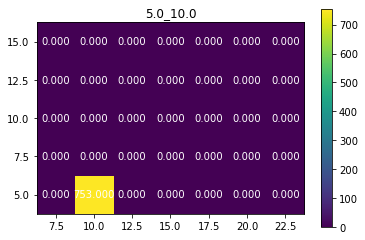

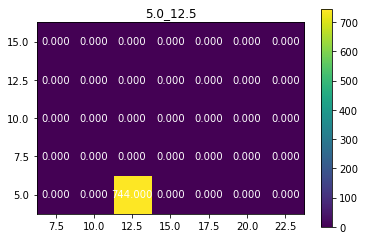

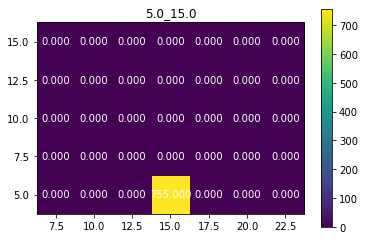

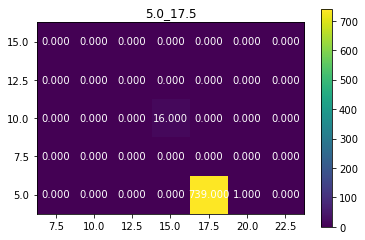

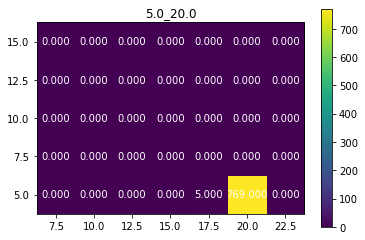

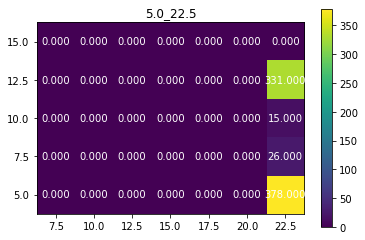

In [15]:
for class_name in data_dictionary:
    create_class_heatmap(class_name, data_dictionary, classification_array)


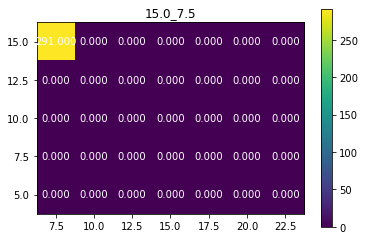

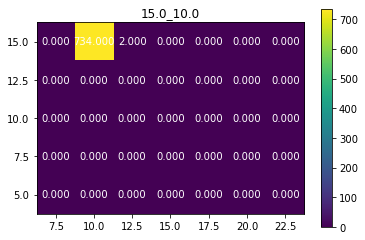

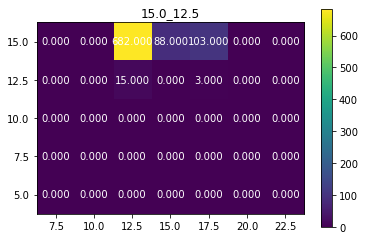

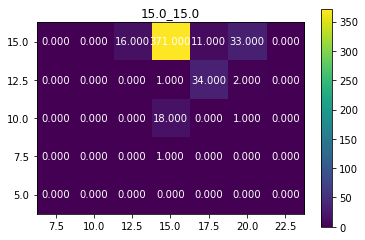

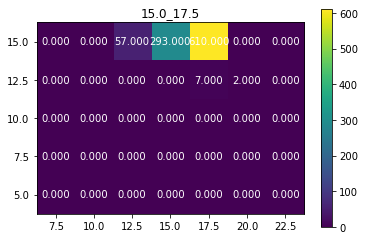

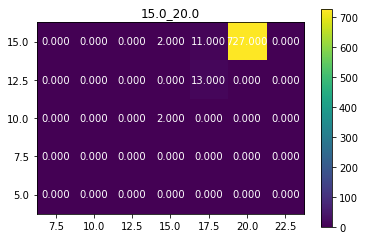

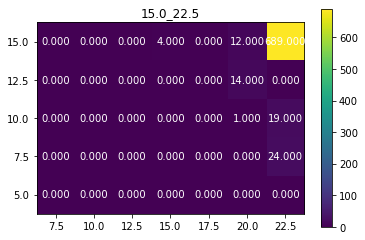

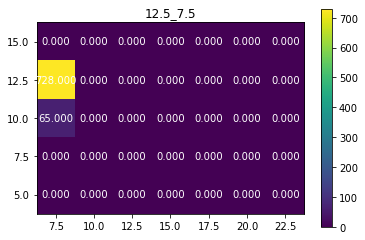

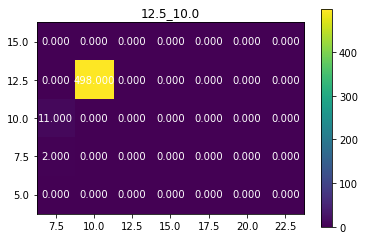

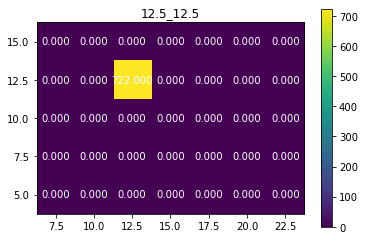

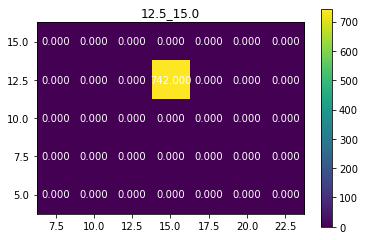

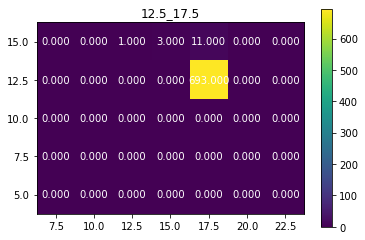

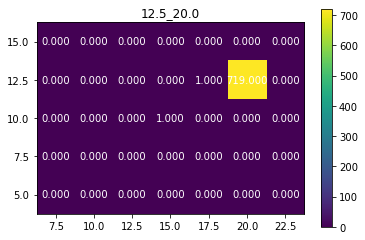

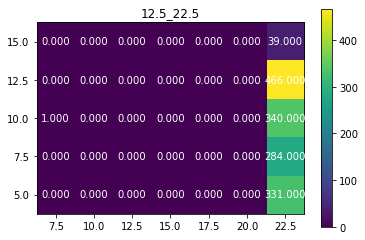

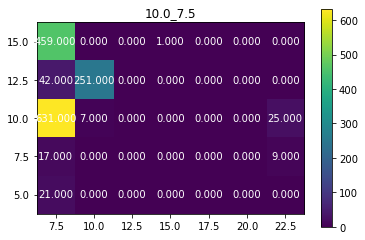

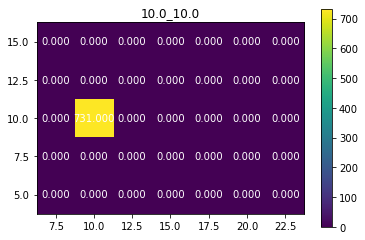

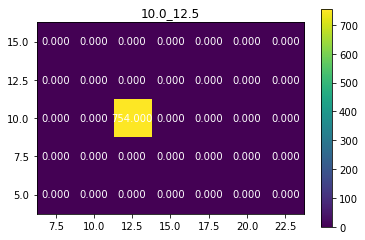

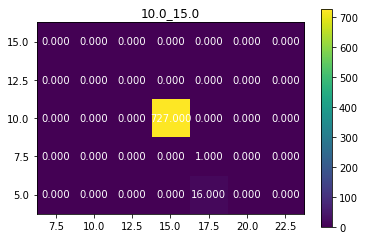

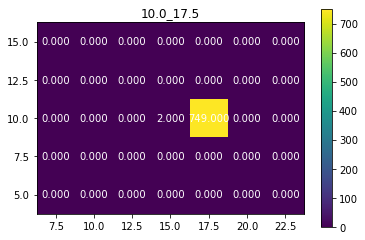

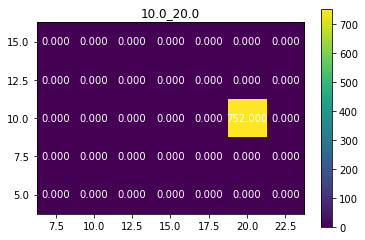

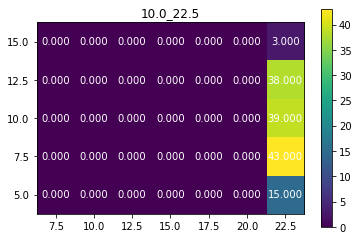

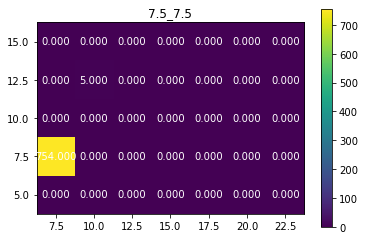

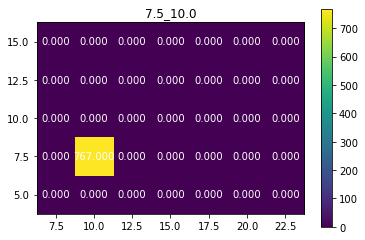

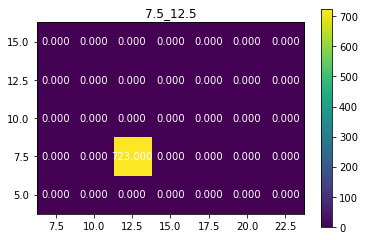

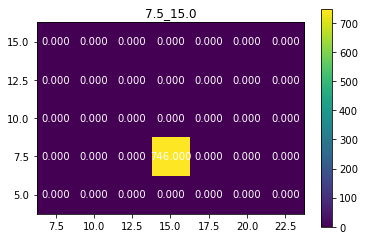

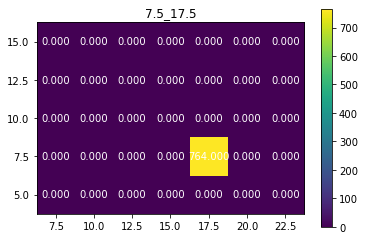

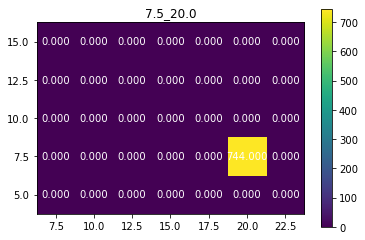

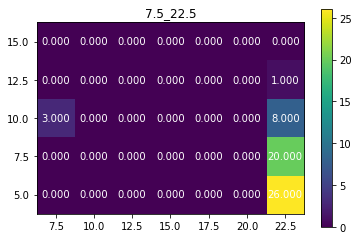

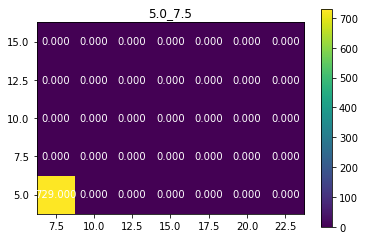

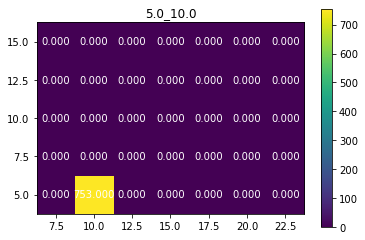

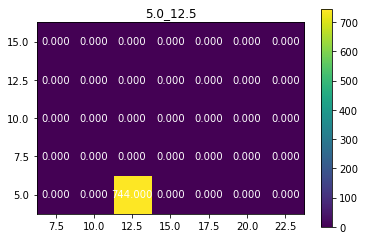

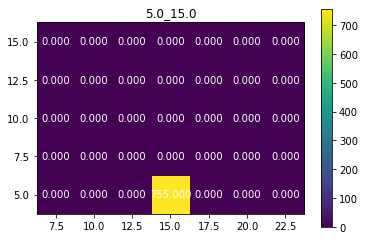

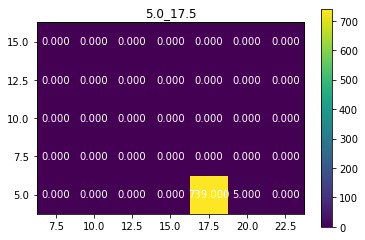

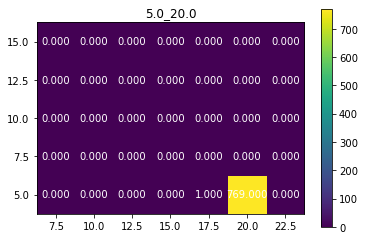

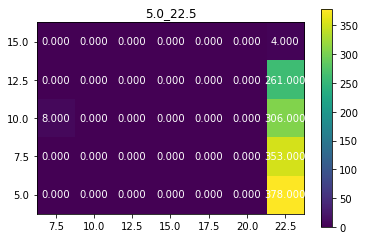

In [16]:
for class_name in data_dictionary:
    create_class_heatmap(class_name, data_dictionary, classification_array, True)

In [1]:
calculate_recall(classification_array)

NameError: name 'calculate_recall' is not defined

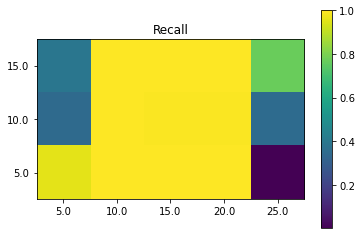

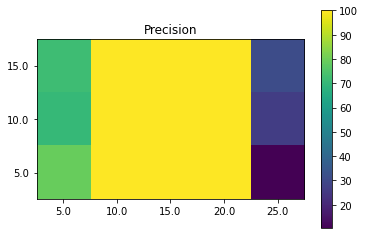

In [16]:
create_heatmap("Recall", data_dictionary, calculate_recall(classification_array))
create_heatmap("Precision", data_dictionary, calculate_precision(classification_array))

In [13]:
error_rate = evaluate(test_set, train_set)
print(error_rate)
print(f"Accuracy: {(1-error_rate)*100:.02f}%")

0.07706666666666667
Accuracy: 92.29%


## k-krotna walidacja

Podział danych na $k$ zbiorów do walidacji. Wynikiem działania jest lista o $k$ elementach [zbiór testowy], [zbiór treningowy]. Zbiory testowe liczą $\lfloor n/k \rfloor$ elementów z wyjątkiem ostatniego, który liczy $n - (k-1)\lfloor n/k \rfloor$. W szczególności gdy $n$ jest podzielne przez $k$, to zwrócone zostaje $k$ równych zbiorów. Wraz zbiorem, w liście zwracane jest jego dopełnienie.

In [29]:
def k_split(array, k):
    sets = []
    np.random.shuffle(array)
    set_length = int(len(array)/k)
    for i in range(k-1):
        sets.append([array[i*set_length:(i+1)*set_length], array[:i*set_length]+array[(i+1)*set_length:]])
    sets.append([array[(k-1)*set_length:], array[:(k-1)*set_length]])
    return sets

Uzyskanie ze zbioru danych listy opisującej wartości danego atrybutu, dla danej klasy (jeśli klasa nie jest podana, zwracana jest lista z całego zbioru)

We wcześniejszym fragmencie liczby 11 i 12 oznaczające 12 i 13 atrybut zostały wybrane nieprzypadkowo. Została przeprowadzana walidacja krzyżowa, która sprawdziła dla jakiej pary atrybutów zostaną osiągnięte najlepsze wyniki. Funkcja ją realizujące przyjmuje jako argument zbiór danych oraz parametr $k$.

In [36]:
def k_cross_validation(k, data):
    valid_sets = k_split(data, k)
    error_rate = 0
    for train_test in valid_sets:
        error_rate += evaluate(train_test[0], train_test[1])
    accuracy = 1 - error_rate/k
    print(f"Average accuracy: {100*accuracy:.2f}%")


In [37]:
k_cross_validation(4, data)

Average accuracy: 98.85%


In [65]:
train_set, test_set = split_into_sets(0.75, data)
train_par = train(train_set)

In [66]:
# class_vector with test
class_vector = split_into_classes(train_set, data_dictionary, decode)
for i in range(len(class_vector)):
    for element in class_vector[i]:
        if (element[1] != i+1): raise Exception()
    print(len(class_vector[i]))

746
736
766
773
771
741
742
747
751
740
732
731
750
765
759


## Rozkład prawdopodobieństwa dla atrybutów - wykresy

W realizacji założono, że rozkład wartości dla atrybutu może być opisany za pomocą rozkładu normalnego aby mozna było policzyć wartość $P(x_i|y)$ gdy $x_i$ nie przyjmuje wartości dyskretnych.

Poniżej zdefiniowana została pomocnicza funkcja, która pozwala na stworzenie wykresu pokazującego rozkład dla wartości podanego jako parametr atrybutu i funkcję rozkładu normalnego utworzoną z tych danych.

In [70]:
colors = [(np.random.choice(range(256), size=3)/255) for _ in range (len(data_dictionary))]

In [71]:
def plot_feature(data, feature):
    nbins = 10
    transparency = 0.5
    for element in data_dictionary:
        flist = get_feature(data, feature, data_dictionary[element])
        r, g, b = colors[data_dictionary[element]-1]
        plt.hist(flist, bins=nbins, density=True, fc=(r, g, b, transparency), label="Klasa " + str(data_dictionary[element]) + " - " + element)
        idx = np.linspace(*plt.xlim(), 100)
        val = [gauss(x, stat.mean(flist), stat.stdev(flist)) for x in idx]
#         print(stat.mean(flist), stat.stdev(flist))
        plt.plot(idx, val, color=(r, g, b, 1), label="Klasa " + str(data_dictionary[element]) + " - " + element)
    plt.title(f"Wykres dla atrybutu o indeksie {feature}")
    plt.legend()
    plt.show()

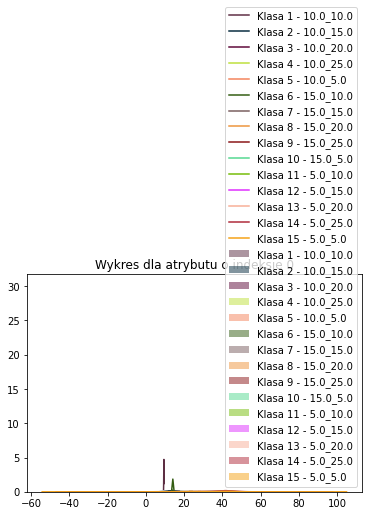

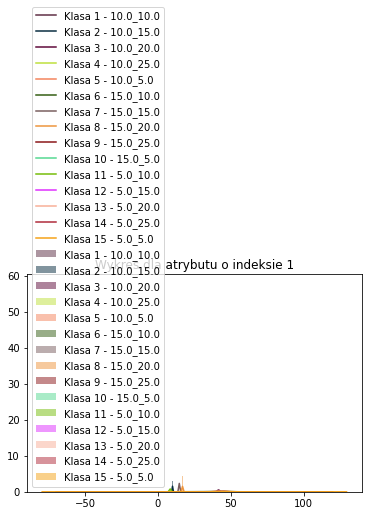

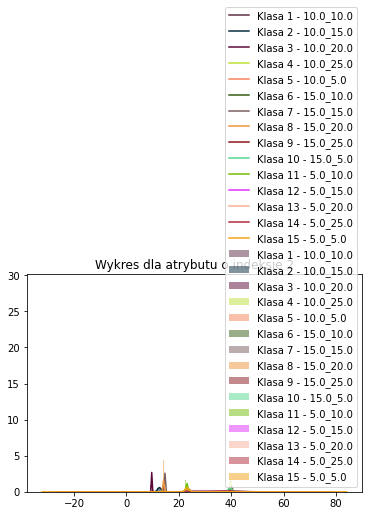

In [72]:
for i in range(3):
    plot_feature(data,i)